# SSVEP Character Classification with DiffE

In [ ]:
!pip install ema-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import sys

!git clone https://github.com/diffe2023/Diff-E.git
sys.path.append('/content/Diff-E')


Cloning into 'Diff-E'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 160 (delta 43), reused 27 (delta 26), pack-reused 105 (from 1)
Receiving objects: 100% (160/160), 53.41 KiB | 7.63 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
import math
from einops import reduce
from functools import partial
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#load and preprocess data


We retain the original SSVEP data preprocessing procedures, including:

    Chebyshev bandpass filtering (6–90 Hz),
    Noise removal and segmentation using a sliding window of 250 samples, followed by manual channel-wise standardization (subtracting the mean and dividing by the standard deviation),
    Downsampling from 1000 Hz to 250 Hz.

In this work, we directly load the preprocessed character-level files "S#_chars.npy" for subsequent training.

Unlike the original setup where models are trained separately for each subject, we train a single model jointly across all subjects by concatenating all subjects' data.

In [ ]:
# Define a function to perform z-score normalization on the data
def zscore_norm(data):
    # Calculate the mean and standard deviation for each channel in each batch
    mean = torch.mean(data, dim=(1, 2))
    std = torch.std(data, dim=(1, 2))

    # Subtract the mean from each channel in each batch and divide by the standard deviation
    norm_data = (data - mean[:, None, None]) / std[:, None, None]

    return norm_data


# Define a function to perform min-max normalization on the data
def minmax_norm(data):
    # Calculate the minimum and maximum values for each channel and sequence in the batch
    min_vals = torch.min(data, dim=-1)[0]
    max_vals = torch.max(data, dim=-1)[0]

    # Scale the data to the range [0, 1]
    norm_data = (data - min_vals.unsqueeze(-1)) / (
        max_vals.unsqueeze(-1) - min_vals.unsqueeze(-1)
    )

    return norm_data

In [ ]:
class EEGDataset(Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, X, Y, transform=None):
        "Initialization"
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]
        if self.transform:
            x = self.transform(x)
        return x.squeeze(), y

In [ ]:
def load_data_by_session(root_dir, subject_id, session_idx_list):
    data = np.load(os.path.join(root_dir, f"S{subject_id}_chars.npy"))  # [26, 6, 64, 250]
    data = data[:, session_idx_list]  # [26, len(session), 64, 250]
    X = data.reshape(-1, 64, 250)
    Y = np.repeat(np.arange(26), len(session_idx_list))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

def load_split_dataset(root_dir, num_seen=25, seed=43):
    random.seed(seed)

    all_subjects = list(range(1, 36))
    seen_subjects = random.sample(all_subjects, num_seen)#25 seen
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]#10 unseen

    split_cfg = {
        "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
        "val":    [(sid, [4]) for sid in seen_subjects],
        "test1":  [(sid, [5]) for sid in seen_subjects],
        "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
    }

    print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

    loaders = {}
    for split, sid_sess in split_cfg.items():
        X_all, Y_all = [], []
        for sid, sess in sid_sess:
            X, Y = load_data_by_session(root_dir, sid, sess)
            X_all.append(X)
            Y_all.append(Y)
        X_all = torch.cat(X_all, dim=0)
        Y_all = torch.cat(Y_all, dim=0)
        dataset = EEGDataset(X_all, Y_all)
        loaders[split] = DataLoader(dataset, batch_size=32, shuffle=(split == "train"))
    return loaders


In [ ]:
seed = 44
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  44


In [ ]:
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44
shuffle = True

# load all subjects' data
loaders = load_split_dataset(subject_chars_dir, num_seen=20, seed=seed)
train_loader = loaders["train"]
val_loader = loaders["val"]
test1_loader = loaders["test1"]
test2_loader = loaders["test2"]


[Split] Seen subjects (train/val/test1): [27, 34, 8, 12, 13, 33, 10, 1, 30, 4, 19, 28, 26, 6, 17, 29, 31, 25, 11, 32]
[Split] Unseen subjects (test2): [2, 3, 5, 7, 9, 14, 15, 16, 18, 20, 21, 22, 23, 24, 35]


In [ ]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test1_loader.dataset), len(test2_loader.dataset))

for x, y in train_loader:
    print("X shape:", x.shape)
    print("Y shape:", y.shape)
    break  # the first batch

2080 520 520 2340
X shape: torch.Size([32, 64, 250])
Y shape: torch.Size([32])


train: 20 seen subjects × 4 session × 26 = 2080

val: 20 × 1 × 26 = 520

test1: 20 × 1 × 26 = 520

test2: 15 unseen × 6 session × 26 = 2340

random choose 25 subjects as seen, the rest 10 as unseen

| Group Name | Subject Range   | Sessions Used         | Purpose                                  |
|------------|------------------|------------------------|-------------------------------------------|
| train      | seen subjects    | sessions [0, 1, 2, 3]  | Training (4 sessions)                     |
| val        | seen subjects    | session [4]            | Validation                                |
| test1      | seen subjects    | session [5]            | Test on unseen session of seen subjects  |
| test2      | unseen subjects  | sessions [0–5] (all)   | Test on unseen subjects                   |


val:2 session
test1:2 sessions
test2:1 subject

#model

The overall model follows the original GitHub implementation, with a few necessary adjustments to align tensor time dimensions. Specifically, we aligned the temporal dimensions between up2 + temb and down1, up3 and x, and x_hat and x. These changes are clearly marked with comments in the code.

In [ ]:
#define diffE model
def get_padding(kernel_size, dilation=1):
    return int((kernel_size * dilation - dilation) / 2)


# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class WeightStandardizedConv1d(nn.Conv1d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv1d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class ResidualConvBlock(nn.Module):
    def __init__(self, inc: int, outc: int, kernel_size: int, stride=1, gn=8):
        super().__init__()
        """
        standard ResNet style convolutional block
        """
        self.same_channels = inc == outc
        self.ks = kernel_size
        self.conv = nn.Sequential(
            WeightStandardizedConv1d(inc, outc, self.ks, stride, get_padding(self.ks)),
            nn.GroupNorm(gn, outc),
            nn.PReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv(x)
        if self.same_channels:
            out = (x + x1) / 2
        else:
            out = x1
        return out


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super(UnetDown, self).__init__()
        self.pool = nn.MaxPool1d(factor)
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        x = self.layer(x)
        x = self.pool(x)
        return x


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super(UnetUp, self).__init__()
        self.pool = nn.Upsample(scale_factor=factor, mode="nearest")
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        x = self.pool(x)
        x = self.layer(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.PReLU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, n_feat=256):
        super(ConditionalUNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.d1_out = n_feat * 1
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.d4_out = n_feat * 4

        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.u1_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)

        self.down1 = UnetDown(in_channels, self.d1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.d1_out, self.d2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.d2_out, self.d3_out, 1, gn=8, factor=2)

        self.up2 = UnetUp(self.d3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.u2_out + self.d2_out, self.u3_out, 1, gn=8, factor=2)
        self.up4 = UnetUp(self.u3_out + self.d1_out, self.u4_out, 1, gn=8, factor=2)
        self.out = nn.Conv1d(self.u4_out + in_channels, in_channels, 1)

    def forward(self, x, t):
        down1 = self.down1(x)  # 2000 -> 1000
        down2 = self.down2(down1)  # 1000 -> 500
        down3 = self.down3(down2)  # 500 -> 250

        temb = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]

        up1 = self.up2(down3)  # 250 -> 500
        up2 = self.up3(torch.cat([up1 + temb, down2], 1))  # 500 -> 1000

        # Align the temporal dimension of up2 + temb and down1
        if (up2 + temb).shape[-1] != down1.shape[-1]:
            target_len = min((up2 + temb).shape[-1], down1.shape[-1])
            up2 = F.interpolate(up2, size=target_len)
            down1 = F.interpolate(down1, size=target_len)

        up3 = self.up4(torch.cat([up2 + temb, down1], 1))  # 1000 -> 2000

        # Align the temporal dimension of up3 and x
        if up3.shape[-1] != x.shape[-1]:
            target_len = min(up3.shape[-1], x.shape[-1])
            up3 = F.interpolate(up3, size=target_len)
            x = F.interpolate(x, size=target_len)

        out = self.out(torch.cat([up3, x], 1))  # 2000 -> 2000

        down = (down1, down2, down3)
        up = (up1, up2, up3)
        return out, down, up


class Encoder(nn.Module):
    def __init__(self, in_channels, dim=512):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.e1_out = dim
        self.e2_out = dim
        self.e3_out = dim

        self.down1 = UnetDown(in_channels, self.e1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.e1_out, self.e2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.e2_out, self.e3_out, 1, gn=8, factor=2)

        self.avg_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        self.max_pooling = nn.AdaptiveMaxPool1d(output_size=1)
        self.act = nn.Tanh()

    def forward(self, x0):
        # Down sampling
        dn1 = self.down1(x0)  # 2048 -> 1024
        dn2 = self.down2(dn1)  # 1024 -> 512
        dn3 = self.down3(dn2)  # 512 -> 256
        z = self.avg_pooling(dn3).view(-1, self.e3_out)  # [b, features]
        down = (dn1, dn2, dn3)
        out = (down, z)
        return out


class Decoder(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.d1_out = n_feat
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        # self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        # self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        # self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        # self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up1 = UnetUp(self.d3_out + self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up2 = UnetUp(self.d2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(
                self.d1_out + self.u3_out + in_channels * 2, in_channels, 1, 1, 0
            ),
        )

        # self.out = nn.Conv1d(self.u4_out+in_channels, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, encoder_out, diffusion_out):
        # Encoder output
        down, z = encoder_out
        dn1, dn2, dn3 = down

        # DDPM output
        x_hat, down_ddpm, up, t = diffusion_out
        dn11, dn22, dn33 = down_ddpm

        # embed context, time step
        # temb = self.sin_emb(t).view(-1, self.n_feat, 1) # [b, n_feat, 1]
        # temb1 = self.timeembed1(temb).view(-1, self.e3_out, 1) # [b, features]
        # temb2 = self.timeembed2(temb).view(-1, self.u2_out, 1) # [b, features]
        # temb3 = self.timeembed3(temb).view(-1, self.u3_out, 1) # [b, features]
        # ct2 = self.contextembed2(z).view(-1, self.u2_out, 1) # [b, n_feat, 1]
        # ct3 = self.contextembed3(z).view(-1, self.u3_out, 1) # [b, n_feat, 1]

        # Up sampling
        up1 = self.up1(torch.cat([dn3, dn33.detach()], 1))
        up2 = self.up2(torch.cat([up1, dn22.detach()], 1))
        out = self.up3(
            torch.cat([self.pool(x0), self.pool(x_hat.detach()), up2, dn11.detach()], 1)
        )
        return out


class DiffE(nn.Module):
    def __init__(self, encoder, decoder, fc):
        super(DiffE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.fc = fc

    def forward(self, x0, ddpm_out):
        encoder_out = self.encoder(x0)
        decoder_out = self.decoder(x0, encoder_out, ddpm_out)
        fc_out = self.fc(encoder_out[1])
        return decoder_out, fc_out


class DecoderNoDiff(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(DecoderNoDiff, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = n_feat

        self.sin_emb = SinusoidalPosEmb(n_feat)
        self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up2 = UnetUp(self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.e2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        # self.up4 = UnetUp(self.e1_out+self.u3_out, self.u4_out, 1, 1, gn=in_channels, factor=2, is_res=True)
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(self.u3_out + self.e1_out + in_channels, in_channels, 1, 1, 0),
        )

        self.out = nn.Conv1d(self.u4_out, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, x_hat, encoder_out, t):
        down, z = encoder_out
        dn1, dn2, dn3 = down
        tembd = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]
        tembd1 = self.timeembed1(self.sin_emb(t)).view(
            -1, self.e3_out, 1
        )  # [b, n_feat, 1]
        tembd2 = self.timeembed2(self.sin_emb(t)).view(
            -1, self.u2_out, 1
        )  # [b, n_feat, 1]
        tembd3 = self.timeembed3(self.sin_emb(t)).view(
            -1, self.u3_out, 1
        )  # [b, n_feat, 1]

        # Up sampling
        ddpm_loss = F.l1_loss(x0, x_hat, reduction="none")

        up2 = self.up2(dn3)  # 256 -> 512
        up3 = self.up3(torch.cat([up2, dn2], 1))  # 512 -> 1024
        out = self.up4(
            torch.cat([self.pool(x0), self.pool(x_hat), up3, dn1], 1)
        )  # 1024 -> 2048
        # out = self.out(torch.cat([out, x_hat], 1)) # 2048 -> 2048
        # out = self.out(out)
        return out


class LinearClassifier(nn.Module):
    def __init__(self, in_dim, latent_dim, emb_dim):
        super().__init__()
        self.linear_out = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=emb_dim),
        )

    def forward(self, x):
        x = self.linear_out(x)
        return x


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def sigmoid_beta_schedule(timesteps, start=-3, end=3, tau=1, clamp_min=1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (
        v_end - v_start
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def ddpm_schedules(beta1, beta2, T):
    # assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    beta_t = cosine_beta_schedule(T, s=0.008).float()
    # beta_t = sigmoid_beta_schedule(T).float()

    alpha_t = 1 - beta_t

    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)

    return {
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device

    def forward(self, x):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        x_t = self.sqrtab[_ts, None, None] * x + self.sqrtmab[_ts, None, None] * noise
        times = _ts / self.n_T
        output, down, up = self.nn_model(x_t, times)
        return output, down, up, noise, times

In [ ]:
for x, y in train_loader:
    channels = x.shape[1]
    timepoints = x.shape[2]
    print(f"Sample input shape: {x.shape}  → Channels: {channels}, Timepoints: {timepoints}")
    break

num_classes = 26
ddpm_dim = 128
encoder_dim = 256
fc_dim = 512
n_T = 1000

ddpm_model = ConditionalUNet(in_channels=channels, n_feat=ddpm_dim).to(device)
ddpm = DDPM(nn_model=ddpm_model, betas=(1e-6, 1e-2), n_T=n_T, device=device).to(device)

encoder = Encoder(in_channels=channels, dim=encoder_dim).to(device)
decoder = Decoder(in_channels=channels, n_feat=ddpm_dim, encoder_dim=encoder_dim).to(device)
fc = LinearClassifier(encoder_dim, fc_dim, emb_dim=num_classes).to(device)

diffe = DiffE(encoder, decoder, fc).to(device)

print(" Model initialized with:")
print(" - Input channels       :", channels)
print(" - Timepoints           :", timepoints)
print(" - ddpm total params    :", sum(p.numel() for p in ddpm.parameters()))
print(" - encoder total params :", sum(p.numel() for p in encoder.parameters()))
print(" - decoder total params :", sum(p.numel() for p in decoder.parameters()))
print(" - classifier params    :", sum(p.numel() for p in fc.parameters()))
print(" - total DiffE params   :", sum(p.numel() for p in diffe.parameters()))


Sample input shape: torch.Size([32, 64, 250])  → Channels: 64, Timepoints: 250
 Model initialized with:
 - Input channels       : 64
 - Timepoints           : 250
 - ddpm total params    : 265478
 - encoder total params : 149763
 - decoder total params : 156482
 - classifier params    : 409628
 - total DiffE params   : 715873


#train

In [ ]:
# Criterion
criterion = nn.L1Loss()
criterion_class = nn.MSELoss()

# Define optimizer
base_lr, lr = 9e-5, 1.5e-3
optim1 = optim.RMSprop(ddpm.parameters(), lr=base_lr)
optim2 = optim.RMSprop(diffe.parameters(), lr=base_lr)

# EMAs
fc_ema = EMA(diffe.fc, beta=0.95, update_after_step=100, update_every=10,)

step_size = 150
scheduler1 = optim.lr_scheduler.CyclicLR(
    optimizer=optim1,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)
scheduler2 = optim.lr_scheduler.CyclicLR(
    optimizer=optim2,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)

In [ ]:
# Evaluate function
def evaluate(encoder, fc, generator, device):
    labels = np.arange(0, 26)
    Y = []
    Y_hat = []
    for x, y in generator:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        encoder_out = encoder(x)
        y_hat = fc(encoder_out[1])
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

    # List of tensors to tensor to numpy
    Y = torch.cat(Y, dim=0).numpy()  # (N, )
    Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 13): has to sum to 1 for each row

    # Accuracy and Confusion Matrix
    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    f1 = f1_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    recall = recall_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    precision = precision_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    auc = roc_auc_score(Y, Y_hat, average="macro", multi_class="ovo", labels=labels)

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "auc": auc,
    }
    # df_cm = pd.DataFrame(confusion_matrix(Y, Y_hat.argmax(axis=1)))
    return metrics


In [ ]:
# Train & Evaluate
args = argparse.Namespace()
args.device = device
args.subject = "ALL"
args.root_dir = subject_chars_dir
subject = args.subject

num_epochs = 500
test_period = 1
start_test = test_period
alpha = 0.1

best_acc = 0
best_f1 = 0
best_recall = 0
best_precision = 0
best_auc = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

with tqdm(total=num_epochs, desc=f"Method ALL - Joint Training on All Subjects") as pbar:
    for epoch in range(num_epochs):
        ddpm.train()
        diffe.train()

        epoch_loss = 0
        num_batches = 0
        epoch_acc = 0
        total_samples = 0

        ############################## Train ###########################################
        for x, y in train_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)
            # Train DDPM
            optim1.zero_grad()
            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            if x_hat.shape[-1] != x.shape[-1]:
                target_len = min(x_hat.shape[-1], x.shape[-1])
                x_hat = F.interpolate(x_hat, size=target_len)
                x = F.interpolate(x, size=target_len)

            loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
            loss_ddpm.mean().backward()
            optim1.step()
            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            optim2.zero_grad()
            decoder_out, fc_out = diffe(x, ddpm_out)

            loss_gap = criterion(decoder_out, loss_ddpm.detach())
            loss_c = criterion_class(fc_out, y_cat)
            loss = loss_gap + alpha * loss_c
            loss.backward()
            optim2.step()

            # Optimizer scheduler step
            scheduler1.step()
            scheduler2.step()

            # EMA update
            fc_ema.update()

            epoch_loss += loss.item()
            num_batches += 1

            pred_labels = torch.argmax(fc_out, dim=1)
            correct = (pred_labels == y).sum().item()
            epoch_acc += correct
            total_samples += y.size(0)

        history["train_loss"].append(epoch_loss / num_batches)
        history["train_acc"].append(epoch_acc / total_samples)

        ############################## validation ###########################################
        with torch.no_grad():
            if epoch > start_test:
                test_period = 1
            if epoch % test_period == 0:
                ddpm.eval()
                diffe.eval()

                metrics_val = evaluate(diffe.encoder, fc_ema, val_loader, device)

                val_acc = metrics_val["accuracy"]
                history["val_acc"].append(val_acc)
                f1 = metrics_val["f1"]
                recall = metrics_val["recall"]
                precision = metrics_val["precision"]
                auc = metrics_val["auc"]

                val_loss = 0
                with torch.no_grad():
                    for x, y in val_loader:
                        x, y = x.to(device), y.type(torch.LongTensor).to(device)
                        y_cat = F.one_hot(y, num_classes=26).float().to(device)

                        x_hat, down, up, noise, t = ddpm(x)
                        ddpm_out = x_hat, down, up, t

                        if x_hat.shape[-1] != x.shape[-1]:
                            target_len = min(x_hat.shape[-1], x.shape[-1])
                            x_hat = F.interpolate(x_hat, size=target_len)
                            x = F.interpolate(x, size=target_len)

                        loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
                        decoder_out, fc_out = diffe(x, ddpm_out)

                        loss_gap = criterion(decoder_out, loss_ddpm)
                        loss_c = criterion_class(fc_out, y_cat)

                        val_loss += (loss_gap + alpha * loss_c).item()
                history["val_loss"].append(val_loss / len(val_loader))

                best_acc_bool = val_acc > best_acc
                best_f1_bool = f1 > best_f1
                best_recall_bool = recall > best_recall
                best_precision_bool = precision > best_precision
                best_auc_bool = auc > best_auc

                if best_acc_bool:
                    best_acc = val_acc
                    #torch.save(diffe.state_dict(), f'/content/drive/MyDrive/project/model/ssvep/diffe_{subject}.pth')
                    torch.save(diffe.state_dict(), '/content/drive/MyDrive/project/model/ssvep/diffe_all_subjects.pth')
                if best_f1_bool:
                    best_f1 = f1
                if best_recall_bool:
                    best_recall = recall
                if best_precision_bool:
                    best_precision = precision
                if best_auc_bool:
                    best_auc = auc

                # print("Subject: {0}".format(subject))
                # # print("ddpm test loss: {0:.4f}".format(t_test_loss_ddpm/len(test_generator)))
                # # print("encoder test loss: {0:.4f}".format(t_test_loss_ed/len(test_generator)))
                # print("accuracy:  {0:.2f}%".format(acc*100), "best: {0:.2f}%".format(best_acc*100))
                # print("f1-score:  {0:.2f}%".format(f1*100), "best: {0:.2f}%".format(best_f1*100))
                # print("recall:    {0:.2f}%".format(recall*100), "best: {0:.2f}%".format(best_recall*100))
                # print("precision: {0:.2f}%".format(precision*100), "best: {0:.2f}%".format(best_precision*100))
                # print("auc:       {0:.2f}%".format(auc*100), "best: {0:.2f}%".format(best_auc*100))
                # writer.add_scalar(f"EEGNet/Accuracy/subject_{subject}", acc*100, epoch)
                # writer.add_scalar(f"EEGNet/F1-score/subject_{subject}", f1*100, epoch)
                # writer.add_scalar(f"EEGNet/Recall/subject_{subject}", recall*100, epoch)
                # writer.add_scalar(f"EEGNet/Precision/subject_{subject}", precision*100, epoch)
                # writer.add_scalar(f"EEGNet/AUC/subject_{subject}", auc*100, epoch)

                # if best_acc_bool or best_f1_bool or best_recall_bool or best_precision_bool or best_auc_bool:
                #     performance = {'subject': subject,
                #                 'epoch': epoch,
                #                 'accuracy': best_acc*100,
                #                 'f1_score': best_f1*100,
                #                 'recall': best_recall*100,
                #                 'precision': best_precision*100,
                #                 'auc': best_auc*100
                #                 }
                #     with open(output_file, 'a') as f:
                #         f.write(f"{performance['subject']}, {performance['epoch']}, {performance['accuracy']}, {performance['f1_score']}, {performance['recall']}, {performance['precision']}, {performance['auc']}\n")
                description = f"Val Accuracy: {val_acc*100:.2f}% | Best: {best_acc*100:.2f}%"
                pbar.set_description(f"Method ALL – Processing subject {subject} – {description}"
                )
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {val_acc*100:.2f}%")
        pbar.update(1)

Method ALL - Joint Training on All Subjects:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1/500] Train Loss: 0.4357 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 2/500] Train Loss: 0.3256 | Val Acc: 3.46%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 3/500] Train Loss: 0.2850 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 4/500] Train Loss: 0.2573 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 5/500] Train Loss: 0.2509 | Val Acc: 3.46%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 6/500] Train Loss: 0.2541 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 7/500] Train Loss: 0.2665 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 8/500] Train Loss: 0.2514 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 9/500] Train Loss: 0.2450 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 10/500] Train Loss: 0.2457 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 11/500] Train Loss: 0.2532 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 12/500] Train Loss: 0.2629 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 13/500] Train Loss: 0.2412 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 14/500] Train Loss: 0.2376 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 15/500] Train Loss: 0.2450 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 16/500] Train Loss: 0.2537 | Val Acc: 5.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 17/500] Train Loss: 0.2479 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 18/500] Train Loss: 0.2399 | Val Acc: 5.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 19/500] Train Loss: 0.2449 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 20/500] Train Loss: 0.2487 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 21/500] Train Loss: 0.2483 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 22/500] Train Loss: 0.2453 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 23/500] Train Loss: 0.2352 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 24/500] Train Loss: 0.2392 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 25/500] Train Loss: 0.2484 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 26/500] Train Loss: 0.2482 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 27/500] Train Loss: 0.2374 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 28/500] Train Loss: 0.2380 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 29/500] Train Loss: 0.2393 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 30/500] Train Loss: 0.2432 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 31/500] Train Loss: 0.2440 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 32/500] Train Loss: 0.2380 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 33/500] Train Loss: 0.2341 | Val Acc: 3.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 34/500] Train Loss: 0.2404 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 35/500] Train Loss: 0.2426 | Val Acc: 4.62%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 36/500] Train Loss: 0.2413 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 37/500] Train Loss: 0.2371 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 38/500] Train Loss: 0.2395 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 39/500] Train Loss: 0.2413 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 40/500] Train Loss: 0.2402 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 41/500] Train Loss: 0.2347 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 42/500] Train Loss: 0.2421 | Val Acc: 4.81%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 43/500] Train Loss: 0.2420 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 44/500] Train Loss: 0.2446 | Val Acc: 4.04%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 45/500] Train Loss: 0.2351 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 46/500] Train Loss: 0.2372 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 47/500] Train Loss: 0.2350 | Val Acc: 4.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 48/500] Train Loss: 0.2403 | Val Acc: 4.81%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 49/500] Train Loss: 0.2418 | Val Acc: 4.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 50/500] Train Loss: 0.2359 | Val Acc: 5.58%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 51/500] Train Loss: 0.2395 | Val Acc: 5.77%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 52/500] Train Loss: 0.2384 | Val Acc: 5.96%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 53/500] Train Loss: 0.2431 | Val Acc: 5.96%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 54/500] Train Loss: 0.2374 | Val Acc: 5.96%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 55/500] Train Loss: 0.2398 | Val Acc: 6.54%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 56/500] Train Loss: 0.2337 | Val Acc: 6.35%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 57/500] Train Loss: 0.2354 | Val Acc: 5.58%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 58/500] Train Loss: 0.2436 | Val Acc: 5.58%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 59/500] Train Loss: 0.2362 | Val Acc: 7.12%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 60/500] Train Loss: 0.2314 | Val Acc: 6.54%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 61/500] Train Loss: 0.2315 | Val Acc: 7.12%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 62/500] Train Loss: 0.2408 | Val Acc: 7.50%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 63/500] Train Loss: 0.2350 | Val Acc: 6.73%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 64/500] Train Loss: 0.2355 | Val Acc: 7.69%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 65/500] Train Loss: 0.2362 | Val Acc: 8.46%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 66/500] Train Loss: 0.2372 | Val Acc: 6.35%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 67/500] Train Loss: 0.2335 | Val Acc: 7.88%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 68/500] Train Loss: 0.2387 | Val Acc: 7.31%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 69/500] Train Loss: 0.2341 | Val Acc: 7.31%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 70/500] Train Loss: 0.2332 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 71/500] Train Loss: 0.2368 | Val Acc: 8.08%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 72/500] Train Loss: 0.2358 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 73/500] Train Loss: 0.2395 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 74/500] Train Loss: 0.2357 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 75/500] Train Loss: 0.2329 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 76/500] Train Loss: 0.2373 | Val Acc: 10.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 77/500] Train Loss: 0.2342 | Val Acc: 10.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 78/500] Train Loss: 0.2360 | Val Acc: 9.42%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 79/500] Train Loss: 0.2307 | Val Acc: 10.58%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 80/500] Train Loss: 0.2382 | Val Acc: 7.69%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 81/500] Train Loss: 0.2396 | Val Acc: 10.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 82/500] Train Loss: 0.2403 | Val Acc: 10.96%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 83/500] Train Loss: 0.2325 | Val Acc: 12.31%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 84/500] Train Loss: 0.2338 | Val Acc: 12.31%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 85/500] Train Loss: 0.2379 | Val Acc: 11.54%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 86/500] Train Loss: 0.2332 | Val Acc: 10.58%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 87/500] Train Loss: 0.2335 | Val Acc: 10.19%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 88/500] Train Loss: 0.2330 | Val Acc: 11.15%
[Epoch 89/500] Train Loss: 0.2319 | Val Acc: 11.35%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 90/500] Train Loss: 0.2389 | Val Acc: 10.19%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 91/500] Train Loss: 0.2369 | Val Acc: 9.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 92/500] Train Loss: 0.2320 | Val Acc: 10.96%
[Epoch 93/500] Train Loss: 0.2368 | Val Acc: 12.69%
[Epoch 94/500] Train Loss: 0.2344 | Val Acc: 9.81%
[Epoch 95/500] Train Loss: 0.2374 | Val Acc: 12.50%
[Epoch 96/500] Train Loss: 0.2346 | Val Acc: 11.73%
[Epoch 97/500] Train Loss: 0.2308 | Val Acc: 12.31%
[Epoch 98/500] Train Loss: 0.2372 | Val Acc: 10.58%
[Epoch 99/500] Train Loss: 0.2337 | Val Acc: 11.15%
[Epoch 100/500] Train Loss: 0.2337 | Val Acc: 12.88%
[Epoch 101/500] Train Loss: 0.2363 | Val Acc: 13.08%
[Epoch 102/500] Train Loss: 0.2347 | Val Acc: 12.50%
[Epoch 103/500] Train Loss: 0.2346 | Val Acc: 12.69%
[Epoch 104/500] Train Loss: 0.2391 | Val Acc: 11.15%
[Epoch 105/500] Train Loss: 0.2319 | Val Acc: 12.88%
[Epoch 106/500] Train Loss: 0.2352 | Val Acc: 12.31%
[Epoch 107/500] Train Loss: 0.2360 | Val Acc: 12.31%
[Epoch 108/500] Train Loss: 0.2316 | Val Acc: 11.73%
[Epoch 109/500] Train Loss: 0.2372 | Val Acc: 12.50%
[Epoch 110/500] Train Loss: 0.2342 | Val Acc: 13.85%
[E

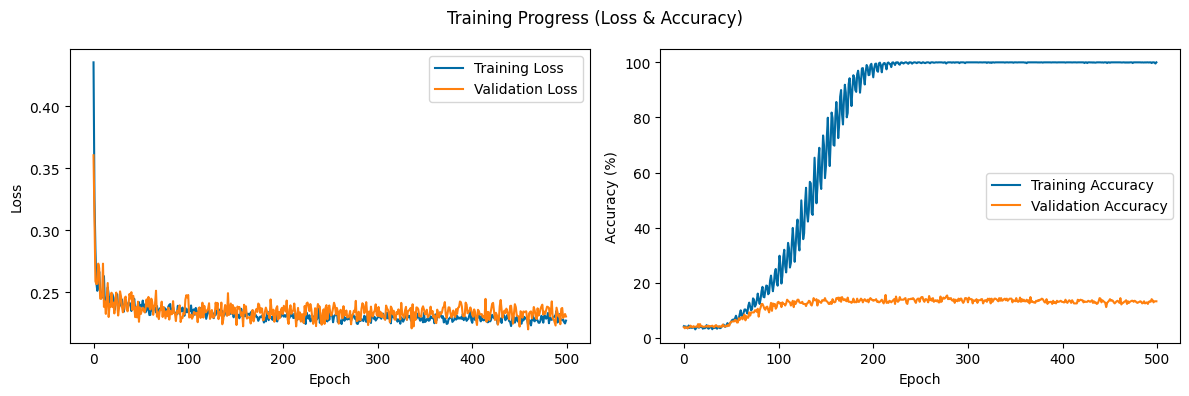

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in history["train_acc"]], label="Training Accuracy")
plt.plot([v * 100 for v in history["val_acc"]], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.suptitle("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.show()

#Evaluate on test data

In [ ]:
def evaluate_on_loader(test_loader, name="test"):
    diffe.eval()
    labels = np.arange(0, 26)
    Y, Y_hat = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            encoder_out = diffe.encoder(x)
            y_hat = diffe.fc(encoder_out[1])
            y_hat = F.softmax(y_hat, dim=1)

            Y.append(y.detach().cpu())
            Y_hat.append(y_hat.detach().cpu())

    Y = torch.cat(Y, dim=0).numpy()
    Y_hat = torch.cat(Y_hat, dim=0).numpy()

    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    print(f" {name} Accuracy: {accuracy:.2%}")
    return accuracy

In [ ]:
acc1 = evaluate_on_loader(test1_loader, name="Test1 (Seen Subject)")
acc2 = evaluate_on_loader(test2_loader, name="Test2 (Unseen Subject)")

 Test1 (Seen Subject) Accuracy: 12.12%
 Test2 (Unseen Subject) Accuracy: 9.02%
